In [4]:
from sys import platform as sys_pf
# if sys_pf == 'darwin':
#     import matplotlib
#     matplotlib.use("TkAgg")
# ! pip install simpleitk
%matplotlib inline  
import os
import numpy as np
# import nibabel as nib
from matplotlib import pyplot as plt
import matplotlib
import SimpleITK as sitk
from scipy import ndimage
import random

folder = 'data/'

690


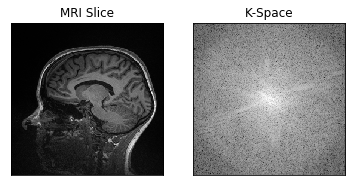

In [5]:
for item in os.listdir(folder):
    if item.endswith(".nii"):
        reader = sitk.ImageFileReader()
        reader.SetImageIO("NiftiImageIO")
        reader.SetFileName(folder + item)
        image = reader.Execute()

        # img1 = sitk.ReadImage(folder + item)  # alternative way to pull in image

        # convert image into np array & perform fft
        img = sitk.GetArrayFromImage(image)
        # print(img.shape)
        orig_slice = img[100]
        
        # FFT in 3d
        v = np.fft.fftn(img)
        
        # shift to get maximum in the middle
        v = np.fft.fftshift(v)
        new_slice = v[100]

        magnitude_spectrum = 20* np.log(np.abs(new_slice))
        back_spectrum = np.fft.fftn(magnitude_spectrum)
        back_img = 20 * np.log(np.abs(back_spectrum))

        back_max = np.amax(back_spectrum)
        back_min = np.amin(back_spectrum)

        back_fft = np.fft.fftn(v)
        back_slice = back_fft[100]

        print(np.amax(orig_slice))

        # plt.subplot(121), plt.imshow(back_img, cmap='gray')
        # plt.title('MRI Slice'), plt.xticks([]), plt.yticks([])
        plt.subplot(121), plt.imshow(orig_slice, cmap='gray')
        plt.title('MRI Slice'), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('K-Space'), plt.xticks([]), plt.yticks([])

In [6]:
print(np.abs(np.sum(new_slice[100])))
print(np.abs(np.sum(magnitude_spectrum[100])))
new_slice[100].real

2.7997597490013512e-09
59697.12352305471


array([ 7.96586293e+02,  1.28850811e+04, -3.01781337e+04, -2.83774093e+04,
       -1.66258684e+04, -1.20703002e+04, -4.87640177e+03,  1.37344734e+04,
        8.73074908e+03,  1.21766195e+04,  2.03243418e+03,  1.40540304e+04,
        3.38205495e+04, -1.35633360e+04, -2.07567480e+04,  7.41514902e+04,
        4.35995455e+02, -2.31110756e+04, -7.48049586e+04, -1.95596352e+04,
       -1.96116994e+04,  3.10393576e+04, -4.22316928e+04,  7.14514470e+03,
        2.86179953e+04,  1.35170074e+05, -1.16751374e+03, -6.32655865e+04,
       -2.94638420e+04,  8.31541959e+03,  8.82338646e+04, -7.61098096e+03,
       -1.10979363e+04, -1.34867331e+05,  3.48836328e+04,  7.19537439e+03,
        5.98895688e+04, -2.51195121e+04, -3.71618881e+04, -2.50932199e+04,
        1.24450374e+05,  1.51651645e+03, -2.66433942e+04, -3.67052401e+04,
        3.82347359e+04,  1.84249967e+04, -8.56668086e+04, -1.15841059e+03,
       -3.38247240e+04,  5.48469321e+04,  5.62530734e+04, -8.99275822e+04,
       -1.21495854e+05,  

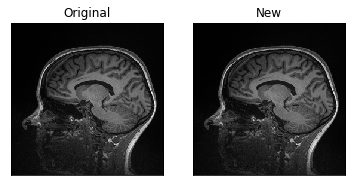

In [15]:
class mri(object):
    def __init__(self, img):
        self.original = img
        self.ks = np.fft.fftn(img)
        self.ks = np.fft.fftshift(self.ks)
        self.max = np.amax(img)
        self.min = np.amin(img)
        self.ks_vis = np.abs(self.ks)
        self.x, self.y, self.z = self.original.shape
        self.slices = self.x
        
    def fft_back(self, kspace):
        # Produce the image given the kspace
        back_fft = np.fft.ifftn(kspace)
        return back_fft
    
    # modifies the whole 3d kspace and then returns a specific slice
    # returns the slice of the modified kspace as well as visual representation
    def mod_kspace_slice(self, trans, rot, rot_axes, slice_num):
        # rotation axes of (1,2) is nodding,(0,2) is shaking, (0,1) is cracking
        mod3d = self.ks.copy()
        mod_v = self.original.copy()
        mod_r = mod3d.real
        mod_i = mod3d.imag
        
        if rot != None:
            mod_v = ndimage.rotate(mod_v, rot, rot_axes, reshape = False)
            mod_r = ndimage.rotate(mod_r, rot, rot_axes, reshape = False)
            mod_i = ndimage.rotate(mod_i, rot, rot_axes, reshape = False)
        if trans != None:
            mod_v = ndimage.shift(mod_v, trans, mode='constant', cval=0)
            mod_r = ndimage.shift(mod_r, trans, mode='constant', cval=0)
            mod_i = ndimage.shift(mod_i, trans, mode='constant', cval=0)
        return mod_r[slice_num] + mod_i[slice_num] *1j, mod_v[slice_num]

    # Translating a specific slice
    # Returns the slice after translation
    def translate(self, space, slice_num, value):
        if space == 'v':
            slc = self.original[slice_num]
        elif space == 'k':
            slc = self.ks_vis[slice_num]
        tran = ndimage.shift(slc,value, mode='constant', cval=0)
        return tran
    
    # Rotating a specific slice
    # Returns the slice after rotation
    def rotate(self, space, slice_num, value, axis=None):
        # If the rotation is in visual space, or k-space
        if space == 'v':
            slc = self.original[slice_num]
            rot = ndimage.rotate(slc, value, reshape = False)
        elif space == 'k':
            slc = self.ks_vis[slice_num]
            rot = ndimage.rotate(slc, value, reshape = False, cval=0)
        return rot
    
    # Displays a slice with an original slice
    def show_slice(self, img, slice_num, space):
        if space == 'v':
            slc = self.original[slice_num]
        elif space == 'k':
            slc = self.ks_vis[slice_num]
        plt.subplot(121), plt.imshow(slc, cmap='gray')
        plt.title('Original'), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(img, cmap='gray')
        plt.title('New'), plt.xticks([]), plt.yticks([])

class motion(object):
    def __init__(self, filename):
        self.filename = filename
        self.motion = np.loadtxt(filename)
mri1 = mri(img)
ks = mri1.ks
new_3d_ks = ks.copy()

new_3d_vs = mri1.fft_back(new_3d_ks)

mri1.show_slice(np.abs(new_3d_vs[100]), 100, 'v')

# testing_3d = ndimage.rotate(new_3d_ks.real, rot, reshape = False)

# steps-
# transform to kspace

# rotate&translate 3d kspace
# get one slice of that modified kspace

# replace rotated slice into original kspace



(Text(0.5, 1.0, 'K-space'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

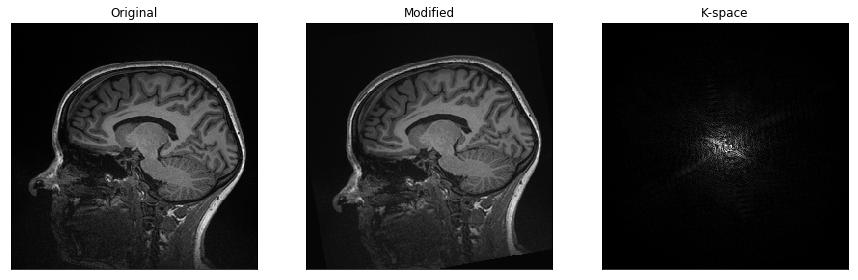

In [9]:
# testing out mod_kspace_slice
# trans = [0,30,0]
trans = None
rot = 10
slice_num = 100
rot_axes = (1,2)
modded_k, modded_v = mri1.mod_kspace_slice(trans,rot,rot_axes,slice_num)
modded_k_vis = np.abs(modded_k)
plt.figure(figsize= (15,5))
plt.subplot(131), plt.imshow(img[slice_num], cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(modded_v, cmap='gray')
plt.title('Modified'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(modded_k_vis, cmap='gray')
plt.title('K-space'), plt.xticks([]), plt.yticks([])

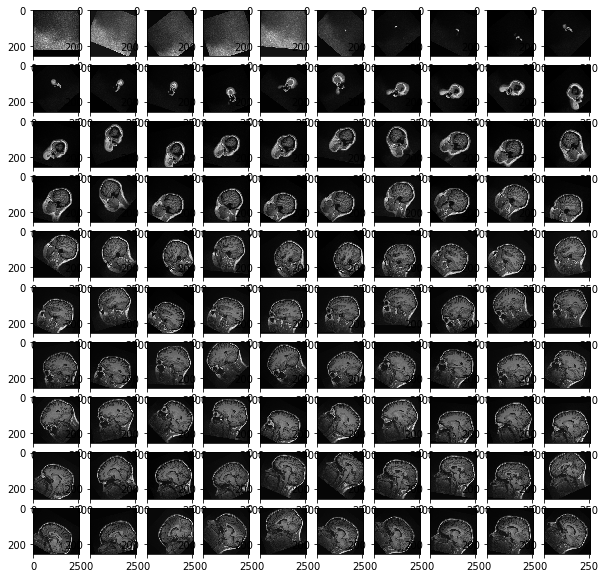

In [11]:
back_fft2 = v.copy()
back_real = back_fft2.real
back_imag = back_fft2.imag

plt.figure(figsize= (10,10))
for i in range(1, 101):
    trans = random.randint(-50,50)
    rot = random.randint(-50,50)
    back_slice_r = back_real[i].copy()
    back_slice_i = back_imag[i].copy()
    img_slice = img[i].copy()

    # Testing translation
    back_rot_r = ndimage.shift(back_slice_r,[trans,0], mode='constant', cval=0)
    back_rot_i = ndimage.shift(back_slice_i,[trans,0], mode='constant', cval=0)
    img_rot = ndimage.shift(img_slice,[trans,0], mode='constant', cval=0)
    

    # Testing rotation
    back_rot_r = ndimage.rotate(back_slice_r, rot, reshape = False)
    back_rot_i = ndimage.rotate(back_slice_i, rot, reshape = False)
    img_rot_out = ndimage.rotate(img_rot, rot, reshape = False)

    back_rot = back_rot_r + back_rot_i * 1j
    back_fft2[i] = back_rot
    plt.subplot(10,10,i), plt.imshow(img_rot_out, cmap='gray')


back_vis = np.fft.ifftn(back_fft2)
back_display = np.abs(back_vis)

# plt.subplot(121), plt.imshow(orig_slice, cmap='gray')
# plt.title('MRI Slice'), plt.xticks([]), plt.yticks([])
# plt.subplot(122), plt.imshow(back_display[100], cmap='gray')
# plt.title('K-Space'), plt.xticks([]), plt.yticks([])

(Text(0.5,1,'Original'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

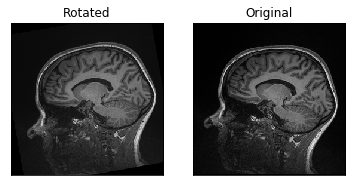

In [7]:
test = ndimage.rotate(back_fft[100],10, reshape = False)

plt.subplot(121), plt.imshow(test, cmap='gray')
plt.title('Rotated'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(back_fft[100], cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

(Text(0.5,1,'Original'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

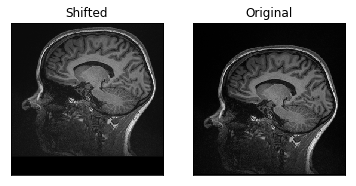

In [8]:
test2 = ndimage.shift(back_fft[100],[-30,0], mode='constant', cval=0)
plt.subplot(121), plt.imshow(test2, cmap='gray')
plt.title('Shifted'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(back_fft[100], cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

In [16]:
motion1 = motion('motion1.dat')
motion1.motion

array([[ 0.00660707, -0.00377952,  0.0133019 , -0.283996  ,  0.134342  ,
         0.0819747 ],
       [ 0.00664416, -0.00274564,  0.0163602 , -0.400296  ,  0.0934326 ,
         0.10443   ],
       [ 0.0109441 , -0.00179819,  0.0161994 , -0.340074  ,  0.173456  ,
        -0.146957  ],
       ...,
       [-0.0154588 ,  0.00428053,  0.012021  , -0.727481  , -0.179043  ,
         0.220468  ],
       [-0.0175203 ,  0.00598954,  0.0110212 , -0.688668  , -0.258359  ,
         0.29105   ],
       [-0.0184072 ,  0.00678847,  0.0108702 , -0.732834  , -0.24174   ,
         0.209552  ]])